# Supervised notebook

In this notebook, we are going to run a model over a new dataset, and re-categorize it's output to augment our training set.

Again, we have to install a million dependencies...

In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'sonumator'
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
!pip install soundfile  

In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash
# Install fastai_audio
data_folder = 'data'
!git clone https://github.com/mogwai/fastai_audio.git
%cd fastai_audio
!git pull
!bash install.sh

Updating fastai...
Done.
Cloning into 'fastai_audio'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 1611 (delta 7), reused 14 (delta 3), pack-reused 1586
Receiving objects: 100% (1611/1611), 173.67 MiB | 28.76 MiB/s, done.
Resolving deltas: 100% (930/930), done.
/content/fastai_audio
Already up to date.
Get:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cu

## Copy files from google cloud

In [ ]:
!gsutil -m cp -r gs://sonumator/output/ /tmp/
!mkdir /tmp/recordings/
!mkdir /tmp/potentials/

Copying gs://sonumator/output/damselfish/0617-114.wav...
Copying gs://sonumator/output/damselfish/0.wav...
Copying gs://sonumator/output/damselfish/0617-116.wav...
Copying gs://sonumator/output/damselfish/0617-176.wav...
Copying gs://sonumator/output/damselfish/100.wav...
Copying gs://sonumator/output/damselfish/10.wav...
Copying gs://sonumator/output/damselfish/101.wav...
Copying gs://sonumator/output/damselfish/1.wav...
Copying gs://sonumator/output/damselfish/103.wav...
Copying gs://sonumator/output/damselfish/102.wav...
Copying gs://sonumator/output/damselfish/104.wav...
Copying gs://sonumator/output/damselfish/11.wav...
Copying gs://sonumator/output/damselfish/105.wav...
Copying gs://sonumator/output/damselfish/106.wav...
Copying gs://sonumator/output/damselfish/110.wav...
Copying gs://sonumator/output/damselfish/107.wav...
Copying gs://sonumator/output/damselfish/108.wav...
Copying gs://sonumator/output/damselfish/111.wav...
Copying gs://sonumator/output/damselfish/109.wav...
Cop

In [ ]:
import math
import glob

import matplotlib.pyplot as plt
import librosa
import torchaudio
import librosa.display
import pandas as pd
import soundfile as sf

from audio import *

from fastai.vision import *
from google.colab import auth

In [ ]:
!rm -rf output/whale/

In [ ]:
path = Path("/tmp/output/")

sg_cfg = SpectrogramConfig(
    f_max=2500., 
    f_min=200.,
    top_db=60,
    hop_length=64,
    n_fft=512,
    n_mels=64,
    pad=0,
)

config = AudioConfig(
    cache=False,
    use_spectro=True,
    sg_cfg=sg_cfg,
)

al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_from_folder()
tfms = None
tfms = get_spectro_transforms(
    size=(128, 314), # Upscale the spectrograms from 128, 39
    mask_frequency=False, # Don't mask frequencies
    mask_time=False # Don't mask time
)
db = al.transform(tfms).databunch(bs=10)

## Load out most recent model

In this next block of code, we load our most recent model so we can run it over more data.

In [ ]:
from fastai.vision import models

learn = audio_learner(db, base_arch=models.resnet50)
learn.load("new_spectrograms")
learn.model.eval()

# Sanity check

The output of the next cell should say `Category damselfish` and not `Category noise`.
That means that the model was loaded and can correctly identify sounds it was trained on.

In [ ]:
# Sanity check that our model can identify samples we trained it on
tmpfile="/tmp/output/damselfish/20.wav"
item = AudioItem(path=tmpfile)
(category, _, _) = audio_predict(learn, item)
category

NameError: ignored

In [ ]:
import torchaudio
import pandas as pd
import soundfile as sf
import os

def search_file_for_samples(filepath, model, offset=2):
    df = pd.DataFrame(columns=["start", "end", "filepath"])

    si, ei = torchaudio.info(filepath)
    length = si.length / si.rate

    for i in range(0, 1000, offset):
        end = i + offset

        y, sr = librosa.load(
            filepath,
            sr=5000,
            offset=i,
            duration=2,
        )
        tmpfile = f"/tmp/potentials/{os.path.basename(filepath)[:-4]}-{i}.wav"
        sf.write(tmpfile, y, 5000)
        item = AudioItem(path=tmpfile)
        category, _, _ = audio_predict(learn, item)
        if str(category) == "damselfish":
            df = df.append([{"start": i, "end": end, "filepath": filepath}])
        else:
            os.remove(tmpfile)
        
    return df

## Fetch a recording from google cloud to classify

In the `fetch_recording` call, you can change the filename to get a new file.

In [ ]:
from subprocess import call

def fetch_recording(gs_path):
  return_code = call(["gsutil", "cp", gs_path, "/tmp/recordings/"])
  print(return_code)
fetch_recording("gs://sonumator/recordings/2015-2016/20151028-180505.wav")

0


## Run the model

And output a list of times we found a potential damselfish call.

In [ ]:
df = search_file_for_samples("/tmp/recordings/20151028-180505.wav", learn)
df.index = range(len(df.index))
df

start  end                             filepath
0      8   10  /tmp/recordings/20151028-180505.wav
1     12   14  /tmp/recordings/20151028-180505.wav
2     28   30  /tmp/recordings/20151028-180505.wav
3     30   32  /tmp/recordings/20151028-180505.wav
4     62   64  /tmp/recordings/20151028-180505.wav
..   ...  ...                                  ...
68   866  868  /tmp/recordings/20151028-180505.wav
69   878  880  /tmp/recordings/20151028-180505.wav
70   902  904  /tmp/recordings/20151028-180505.wav
71   930  932  /tmp/recordings/20151028-180505.wav
72   960  962  /tmp/recordings/20151028-180505.wav

[73 rows x 3 columns]

In [ ]:
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, MFCC
from IPython.display import Audio
import ipywidgets as widgets

from os import listdir
from os.path import isfile, join

class ButtonHandler:
  def __init__(self, filepath, type):
    basename = os.path.basename(filepath)

    self.filepath = filepath
    self.destination = f"/tmp/output/{type}/{basename}"

  def click(self, event):
    print(f"Ok, I'm moving {self.filepath} to {self.destination}")
    os.rename(self.filepath, self.destination)

def show(filepath):
  sig, sr = torchaudio.load(
      filepath,
  )

  mel = MelSpectrogram(
    f_min=200.0,
    f_max=1000.0,
    hop_length=32,
    n_fft=128,
    n_mels=64,
    pad=0,
    win_length=None
  )(sig)

  mel = AmplitudeToDB(top_db=50)(mel)
  mel = mel.detach()

  print(f"File path {filepath}")
  plt.figure(figsize=(10, 14))
  plt.imshow(mel[0,:,:].detach().numpy(), origin="lower")
  plt.show()
  display(Audio(filepath))
  damsel_button = widgets.Button(
      description='damselfish',
      layout={'width': '150px'},
  )
  d = ButtonHandler(filepath, "damselfish")
  damsel_button.on_click(d.click)
  noise_button = widgets.Button(
      description='noise',
      layout={'width': '150px'},
  )
  n = ButtonHandler(filepath, "noise")
  noise_button.on_click(n.click)
  box = widgets.HBox(children=[damsel_button, noise_button])
  display(box)

## Checking the model

The next block of code will print out all the potential calls the model found.

Below the spectrogram for each call is the audio for the call, and two buttons. Click the button to classify the sound.

File path /tmp/potentials/20151028-180505-102.wav


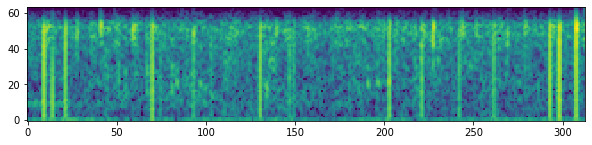

File path /tmp/potentials/20151028-180505-106.wav


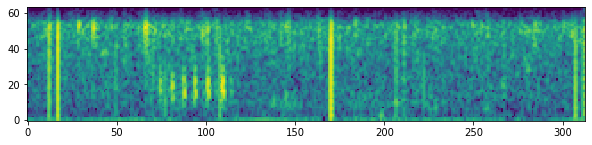

File path /tmp/potentials/20151028-180505-118.wav


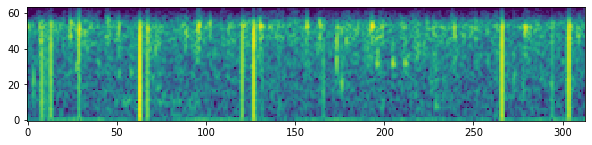

File path /tmp/potentials/20151028-180505-12.wav


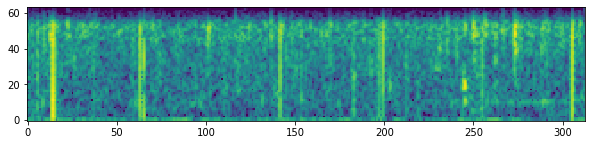

File path /tmp/potentials/20151028-180505-120.wav


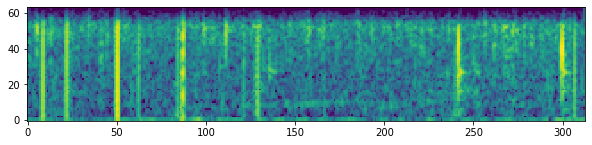

File path /tmp/potentials/20151028-180505-126.wav


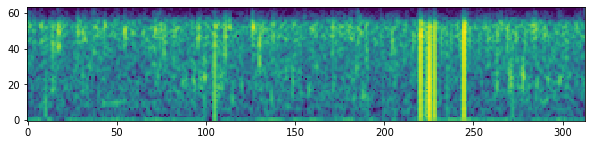

File path /tmp/potentials/20151028-180505-134.wav


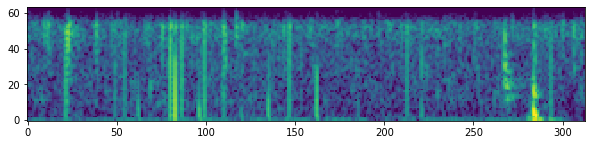

File path /tmp/potentials/20151028-180505-136.wav


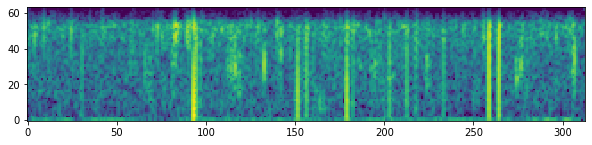

File path /tmp/potentials/20151028-180505-146.wav


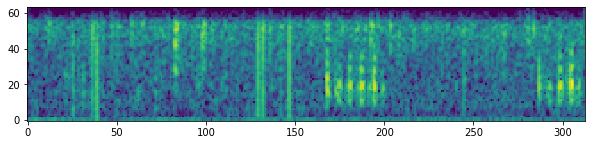

File path /tmp/potentials/20151028-180505-148.wav


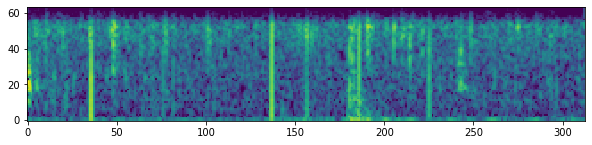

File path /tmp/potentials/20151028-180505-174.wav


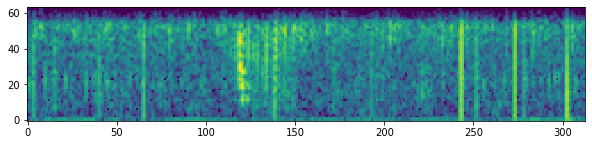

File path /tmp/potentials/20151028-180505-182.wav


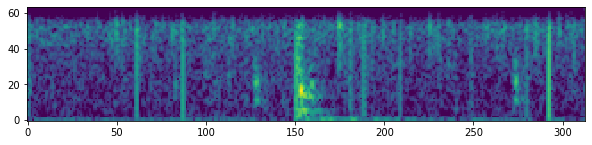

File path /tmp/potentials/20151028-180505-184.wav


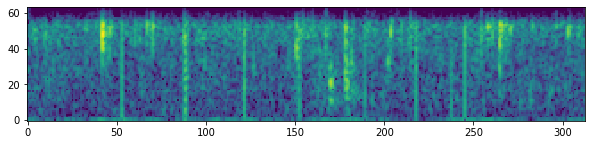

File path /tmp/potentials/20151028-180505-186.wav


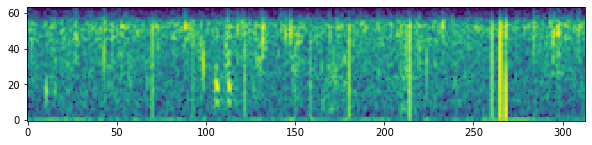

File path /tmp/potentials/20151028-180505-196.wav


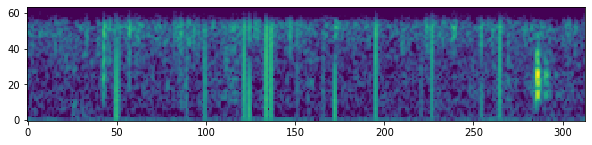

File path /tmp/potentials/20151028-180505-202.wav


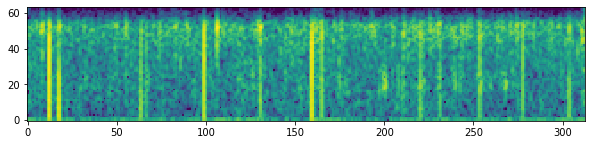

File path /tmp/potentials/20151028-180505-206.wav


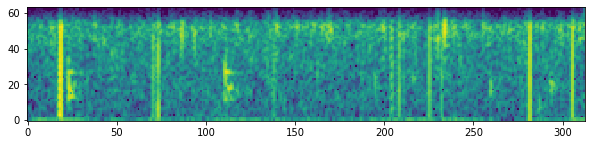

File path /tmp/potentials/20151028-180505-210.wav


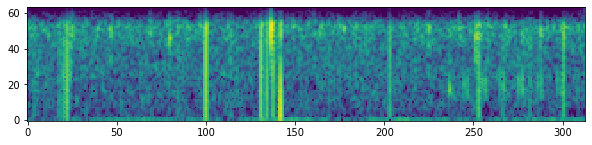

File path /tmp/potentials/20151028-180505-212.wav


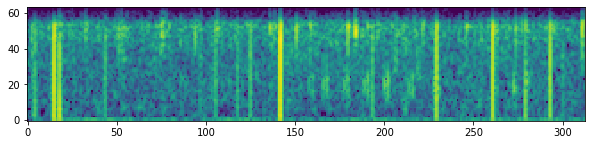

File path /tmp/potentials/20151028-180505-240.wav


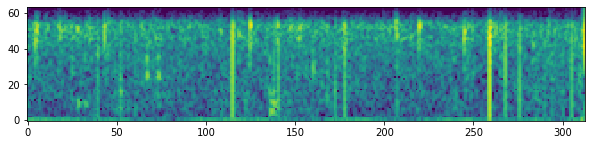

File path /tmp/potentials/20151028-180505-246.wav


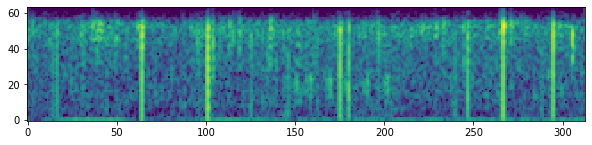

File path /tmp/potentials/20151028-180505-250.wav


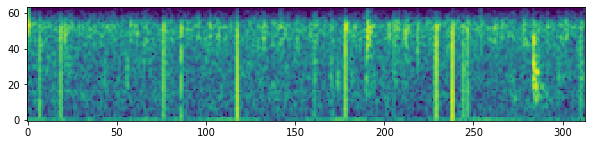

File path /tmp/potentials/20151028-180505-252.wav


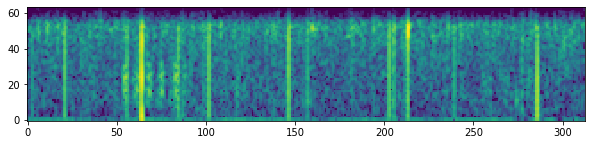

File path /tmp/potentials/20151028-180505-28.wav


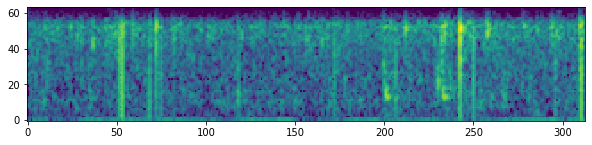

File path /tmp/potentials/20151028-180505-284.wav


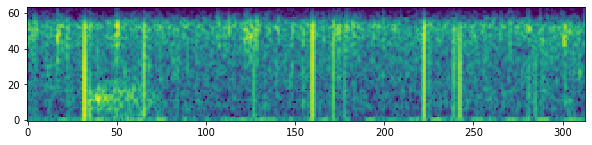

File path /tmp/potentials/20151028-180505-30.wav


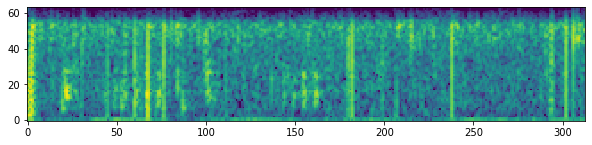

File path /tmp/potentials/20151028-180505-350.wav


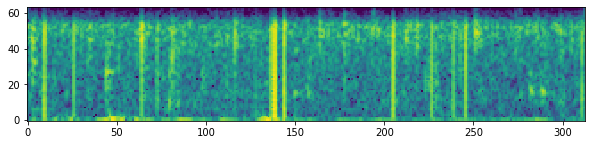

File path /tmp/potentials/20151028-180505-372.wav


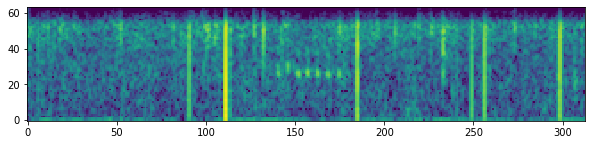

File path /tmp/potentials/20151028-180505-374.wav


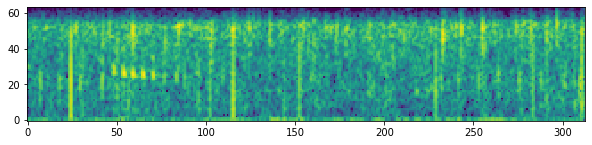

File path /tmp/potentials/20151028-180505-392.wav


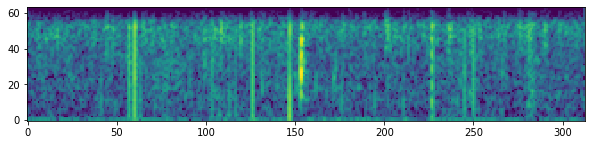

File path /tmp/potentials/20151028-180505-400.wav


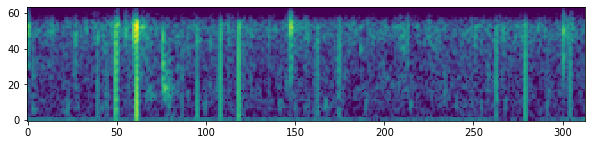

File path /tmp/potentials/20151028-180505-410.wav


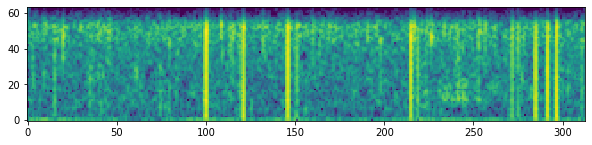

File path /tmp/potentials/20151028-180505-418.wav


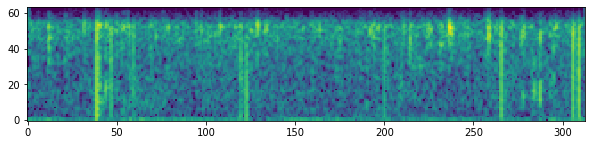

File path /tmp/potentials/20151028-180505-420.wav


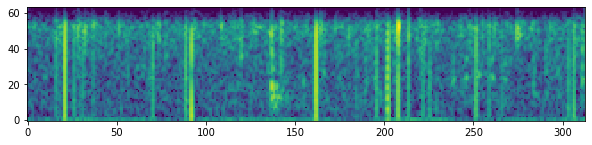

File path /tmp/potentials/20151028-180505-430.wav


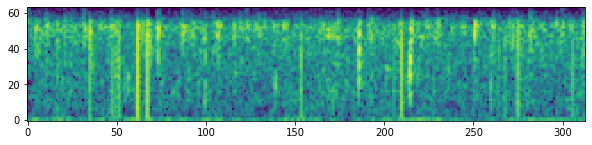

File path /tmp/potentials/20151028-180505-446.wav


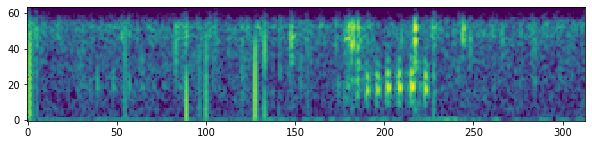

File path /tmp/potentials/20151028-180505-448.wav


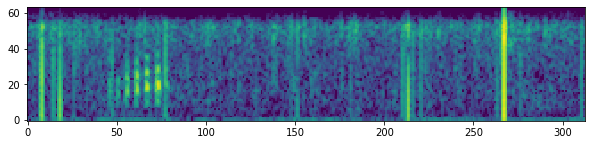

File path /tmp/potentials/20151028-180505-480.wav


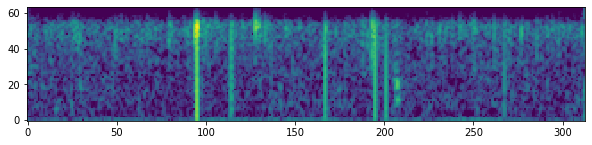

File path /tmp/potentials/20151028-180505-482.wav


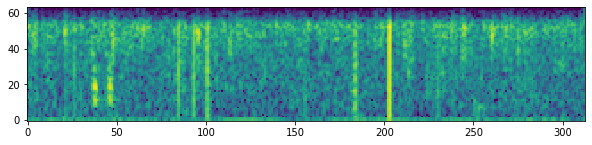

File path /tmp/potentials/20151028-180505-514.wav


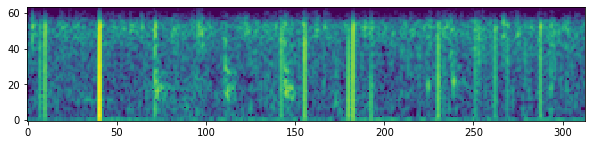

File path /tmp/potentials/20151028-180505-534.wav


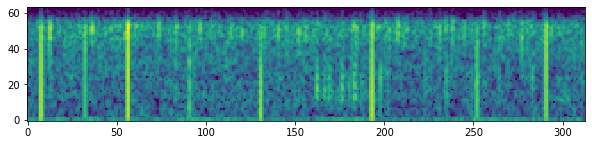

File path /tmp/potentials/20151028-180505-540.wav


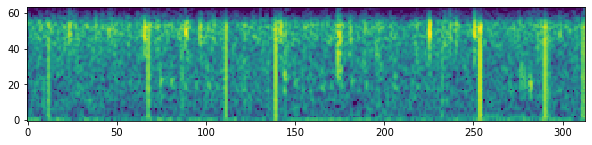

File path /tmp/potentials/20151028-180505-546.wav


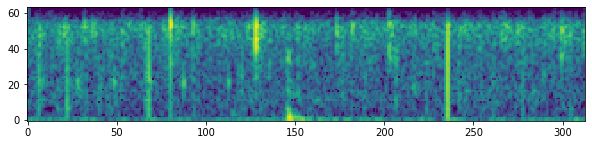

File path /tmp/potentials/20151028-180505-576.wav


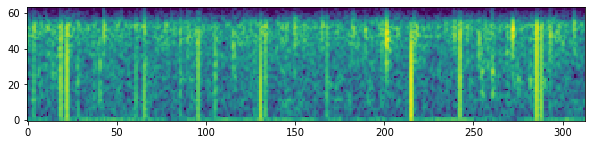

File path /tmp/potentials/20151028-180505-580.wav


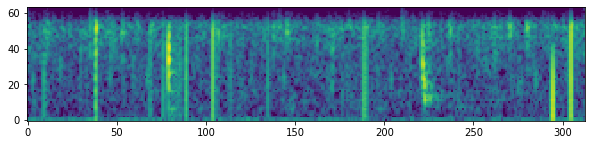

File path /tmp/potentials/20151028-180505-584.wav


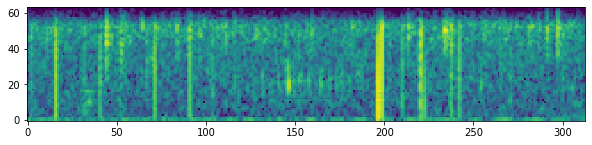

File path /tmp/potentials/20151028-180505-602.wav


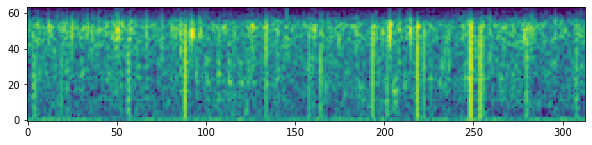

File path /tmp/potentials/20151028-180505-62.wav


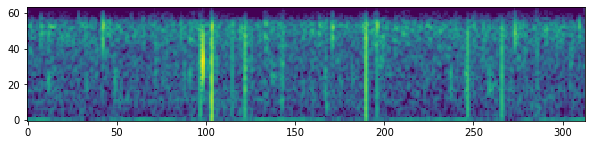

File path /tmp/potentials/20151028-180505-624.wav


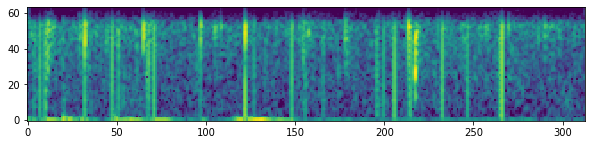

File path /tmp/potentials/20151028-180505-628.wav


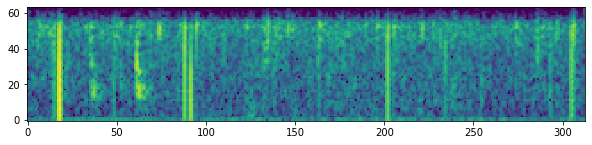

File path /tmp/potentials/20151028-180505-672.wav


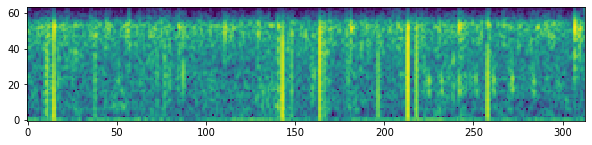

File path /tmp/potentials/20151028-180505-692.wav


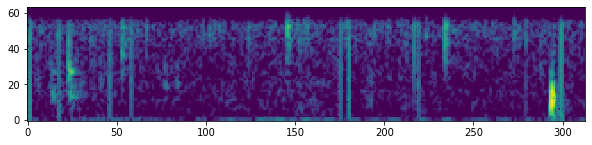

File path /tmp/potentials/20151028-180505-694.wav


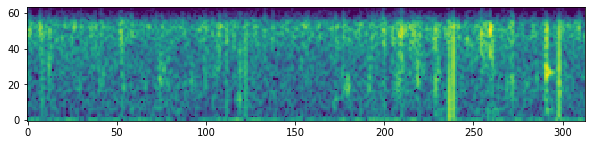

File path /tmp/potentials/20151028-180505-70.wav


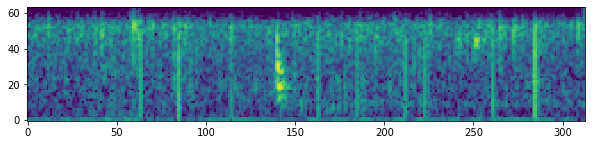

File path /tmp/potentials/20151028-180505-704.wav


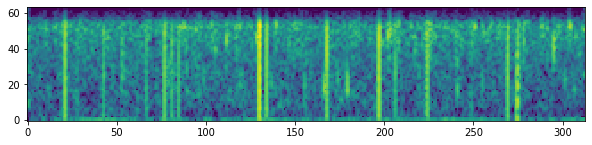

File path /tmp/potentials/20151028-180505-722.wav


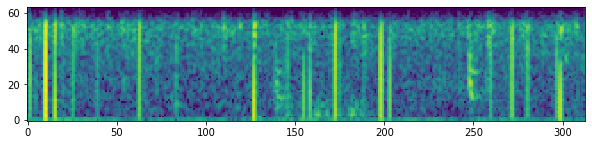

File path /tmp/potentials/20151028-180505-736.wav


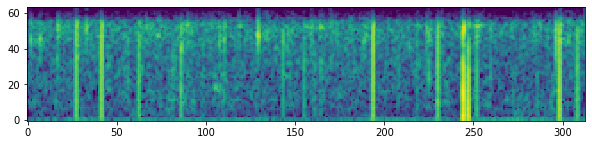

File path /tmp/potentials/20151028-180505-738.wav


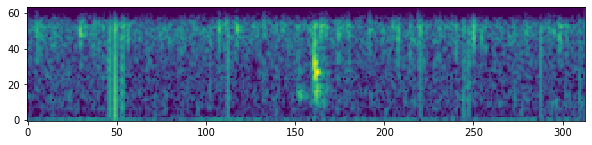

File path /tmp/potentials/20151028-180505-762.wav


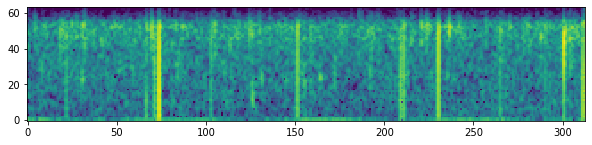

File path /tmp/potentials/20151028-180505-770.wav


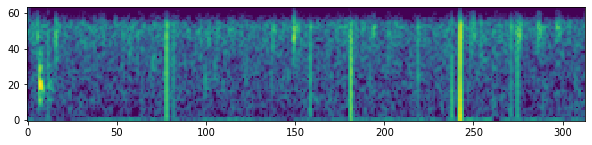

File path /tmp/potentials/20151028-180505-786.wav


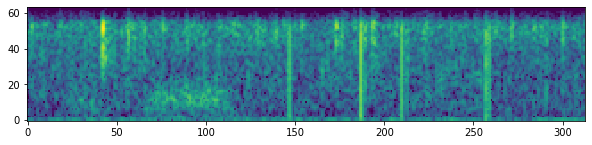

File path /tmp/potentials/20151028-180505-8.wav


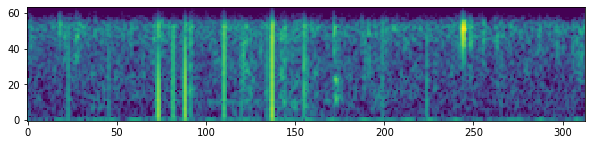

File path /tmp/potentials/20151028-180505-80.wav


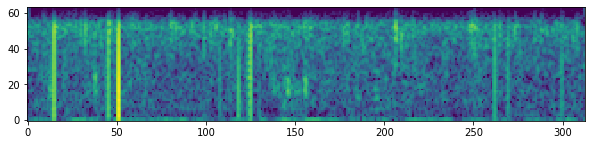

File path /tmp/potentials/20151028-180505-82.wav


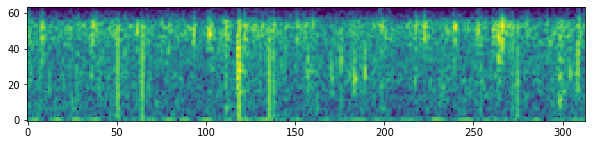

File path /tmp/potentials/20151028-180505-828.wav


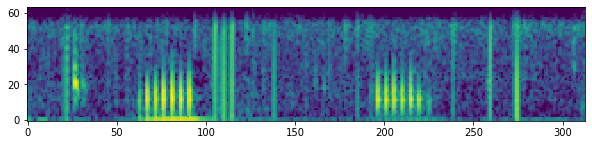

File path /tmp/potentials/20151028-180505-848.wav


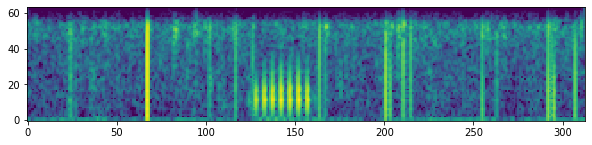

File path /tmp/potentials/20151028-180505-858.wav


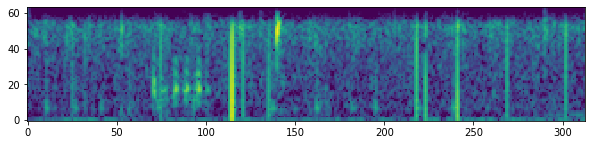

File path /tmp/potentials/20151028-180505-866.wav


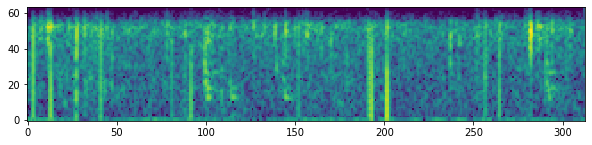

File path /tmp/potentials/20151028-180505-878.wav


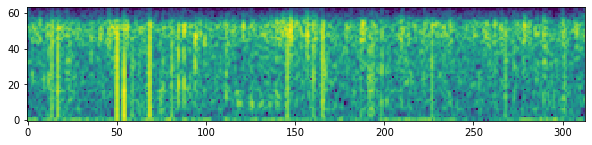

File path /tmp/potentials/20151028-180505-88.wav


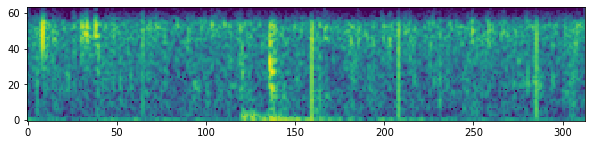

File path /tmp/potentials/20151028-180505-902.wav


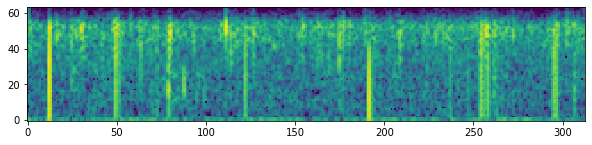

File path /tmp/potentials/20151028-180505-930.wav


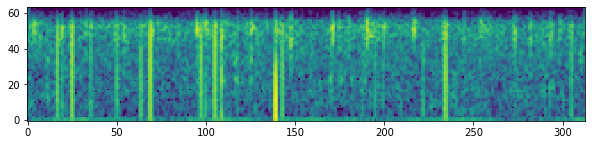

File path /tmp/potentials/20151028-180505-960.wav


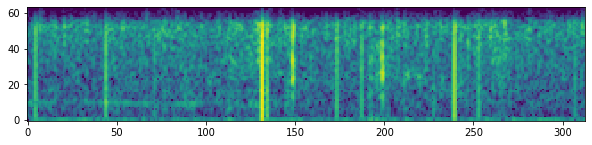

Ok, I'm moving /tmp/potentials/20151028-180505-106.wav to /tmp/output/damselfish/20151028-180505-106.wav
Ok, I'm moving /tmp/potentials/20151028-180505-118.wav to /tmp/output/noise/20151028-180505-118.wav
Ok, I'm moving /tmp/potentials/20151028-180505-12.wav to /tmp/output/noise/20151028-180505-12.wav
Ok, I'm moving /tmp/potentials/20151028-180505-118.wav to /tmp/output/noise/20151028-180505-118.wav


FileNotFoundError: ignored

Ok, I'm moving /tmp/potentials/20151028-180505-106.wav to /tmp/output/damselfish/20151028-180505-106.wav


FileNotFoundError: ignored

Ok, I'm moving /tmp/potentials/20151028-180505-118.wav to /tmp/output/noise/20151028-180505-118.wav


FileNotFoundError: ignored

Ok, I'm moving /tmp/potentials/20151028-180505-12.wav to /tmp/output/noise/20151028-180505-12.wav


FileNotFoundError: ignored

Ok, I'm moving /tmp/potentials/20151028-180505-120.wav to /tmp/output/noise/20151028-180505-120.wav
Ok, I'm moving /tmp/potentials/20151028-180505-134.wav to /tmp/output/noise/20151028-180505-134.wav
Ok, I'm moving /tmp/potentials/20151028-180505-136.wav to /tmp/output/noise/20151028-180505-136.wav
Ok, I'm moving /tmp/potentials/20151028-180505-146.wav to /tmp/output/damselfish/20151028-180505-146.wav
Ok, I'm moving /tmp/potentials/20151028-180505-148.wav to /tmp/output/noise/20151028-180505-148.wav
Ok, I'm moving /tmp/potentials/20151028-180505-174.wav to /tmp/output/noise/20151028-180505-174.wav
Ok, I'm moving /tmp/potentials/20151028-180505-182.wav to /tmp/output/noise/20151028-180505-182.wav
Ok, I'm moving /tmp/potentials/20151028-180505-184.wav to /tmp/output/noise/20151028-180505-184.wav
Ok, I'm moving /tmp/potentials/20151028-180505-186.wav to /tmp/output/noise/20151028-180505-186.wav
Ok, I'm moving /tmp/potentials/20151028-180505-196.wav to /tmp/output/noise/20151028-180505-196

FileNotFoundError: ignored

In [ ]:
mypath = "/tmp/potentials/"
potentials = [f"{mypath}{f}" for f in listdir(mypath) if isfile(join(mypath, f))]
potentials.sort()

for i in range(0, len(potentials)):
  show(potentials[i])

In [ ]:
!ls /tmp/output/damselfish/20151028-180505-30.wav

/tmp/output/damselfish/20151028-180505-30.wav


## Copying files back to Google Cloud

Once you have finished classifying all the potentials, upload the sounds back to google cloud by running the following cell.

In [ ]:
!gsutil -m cp -r /tmp/output/damselfish gs://sonumator/output/
!gsutil -m cp -r /tmp/output/noise gs://sonumator/noise